In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta  # Technical Analysis library
from sklearn.preprocessing import MinMaxScaler

In [99]:
# Define the stock ticker (GOOG in this case)
ticker = 'MSTR'

# Download data from 2010-01-01 to the most recent available date
new_data = yf.download(ticker, start='2010-01-01', end='2025-01-10')

# Preview the new data
new_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSTR,MSTR,MSTR,MSTR,MSTR
Date,,,,,
2010-01-04,9.616,9.625,9.447,9.447,716000
2010-01-05,9.784,9.860,9.667,9.694,1394000
2010-01-06,9.634,9.864,9.610,9.826,647000
2010-01-07,9.249,9.733,9.221,9.609,1707000
2010-01-08,9.500,9.541,9.257,9.257,652000


In [100]:
# Access the 'Close' column using the correct multi-level index
close_prices = new_data[('Close', ticker)]

# Check if it is a 1D pandas Series
print(close_prices.shape)

(3779,)


In [101]:
# Step 3: Calculate technical indicators
# Calculate 20-period SMA (Simple Moving Average)
new_data[('SMA_20', '')] = new_data[('Close', ticker)].rolling(window=20).mean()

# Calculate 20-period EMA (Exponential Moving Average)
new_data[('EMA_20', '')] = new_data[('Close', ticker)].ewm(span=20, adjust=False).mean()

# Calculate 14-period RSI (Relative Strength Index)
new_data[('RSI', '')] = ta.momentum.RSIIndicator(close_prices, window=14).rsi()

# Calculate Bollinger Bands (Upper and Lower)
new_data[('Bollinger_Upper', '')] = new_data[('SMA_20', '')] + 2 * new_data[('Close', ticker)].rolling(window=20).std()
new_data[('Bollinger_Lower', '')] = new_data[('SMA_20', '')] - 2 * new_data[('Close', ticker)].rolling(window=20).std()

# Handle NaN values caused by rolling calculations (forward fill or drop)
new_data.ffill(inplace=True)

new_data.dropna(inplace=True)  # Alternatively, drop rows with NaN values

# Preview the data with the new technical indicators
new_data.head()


Price,Close,High,Low,Open,Volume,SMA_20,EMA_20,RSI,Bollinger_Upper,Bollinger_Lower
Ticker,MSTR,MSTR,MSTR,MSTR,MSTR,,,,,
Date,,,,,,,,,,
2010-02-01,9.437,9.500,9.276,9.409,595000,9.73090,9.693071,43.936555,10.444909,9.016891
2010-02-02,9.466,9.562,9.403,9.437,607000,9.72340,9.671445,44.693750,10.445595,9.001205
2010-02-03,9.664,9.766,9.456,9.458,1325000,9.71740,9.670736,49.690000,10.439469,8.995331
2010-02-04,7.903,8.621,7.779,8.401,11473000,9.63085,9.502380,26.639657,10.717791,8.543908
2010-02-05,7.913,8.078,7.725,7.903,3009000,9.56405,9.351011,26.847184,10.888143,8.239957


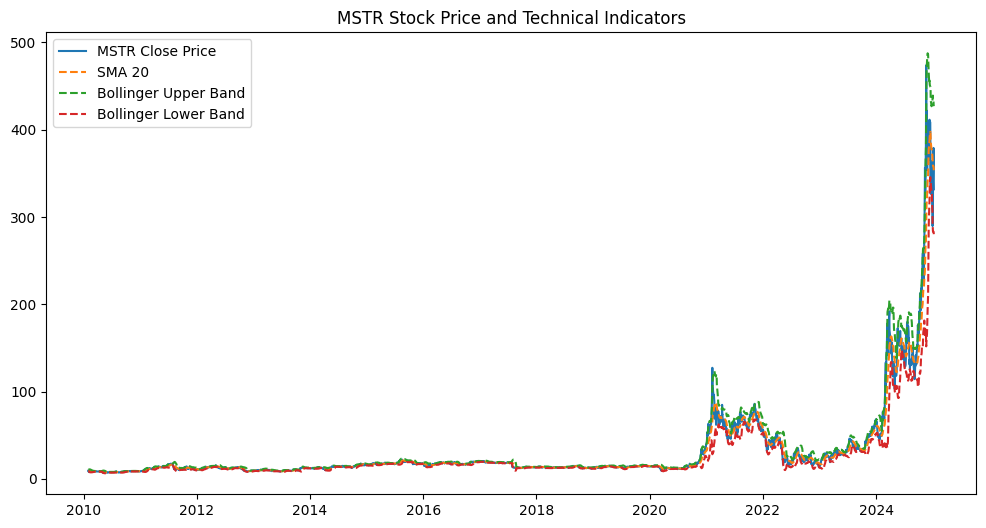

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(new_data['Close'], label=f'{str(ticker)} Close Price')
plt.plot(new_data['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(new_data['Bollinger_Upper'], label='Bollinger Upper Band', linestyle='--')
plt.plot(new_data['Bollinger_Lower'], label='Bollinger Lower Band', linestyle='--')
plt.legend(loc='best')
plt.title(f'{str(ticker)} Stock Price and Technical Indicators')
plt.show()


In [48]:
from sklearn.preprocessing import MinMaxScaler

# Define the columns to normalize
features_to_normalize = [
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'SMA_20',
    'EMA_20',
    'RSI',
    'Bollinger_Upper',
    'Bollinger_Lower'
]

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Normalize the selected features
new_data[features_to_normalize] = scaler.fit_transform(new_data[features_to_normalize])

# Preview the normalized data
new_data.head()


Price,Close,High,Low,Open,Volume,SMA_20,EMA_20,RSI,Bollinger_Upper,Bollinger_Lower
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,
Date,,,,,,,,,,
2010-02-01,0.000319,1.307575e-08,0.000054,0.000000,0.391138,0.001096,0.000649,0.211101,0.001747,0.000902
2010-02-02,0.000453,3.793662e-05,0.000303,0.000423,0.363398,0.000984,0.000536,0.234834,0.001697,0.000723
2010-02-03,0.000854,4.977871e-04,0.000427,0.000334,0.318713,0.000890,0.000474,0.303430,0.001578,0.000658
2010-02-04,0.000000,2.809024e-04,0.000086,0.000520,0.395323,0.000773,0.000332,0.213224,0.001583,0.000409
2010-02-05,0.000406,0.000000e+00,0.000000,0.000031,0.445198,0.000680,0.000245,0.278403,0.001521,0.000282


In [49]:
forecast_horizon = 3


def create_sequences(data, sequence_length, forecast_horizon, target_column='Close'):
    X, y = [], []
    for i in range(sequence_length, len(data) - forecast_horizon + 1):
        # Extract sequence for features
        features = data.iloc[i - sequence_length:i].drop(columns=[target_column]).values
        X.append(features)
        # Extract future horizon for targets
        targets = data.iloc[i:i + forecast_horizon][target_column].values
        y.append(targets)
    return np.array(X), np.array(y)


# Create sequences
X, y = create_sequences(new_data, sequence_length=60, forecast_horizon=forecast_horizon, target_column='Close')

print(f"Features Shape: {X.shape}, Targets Shape: {y.shape}")


Features Shape: (3698, 60, 9), Targets Shape: (3698, 3, 1)


In [50]:
from sklearn.model_selection import train_test_split

# Initial split into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Further split training+validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.18,
                                                  random_state=42)  # 18% of 85% ≈ 15%

# Print shapes of the splits
print(f"Training Data: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation Data: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Testing Data: X_test={X_test.shape}, y_test={y_test.shape}")


Training Data: X_train=(2577, 60, 9), y_train=(2577, 3, 1)
Validation Data: X_val=(566, 60, 9), y_val=(566, 3, 1)
Testing Data: X_test=(555, 60, 9), y_test=(555, 3, 1)


In [51]:
np.savez('processed_goog_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, X_val=X_val,
         y_val=y_val)

In [52]:
# Load preprocessed data
import numpy as np

data = np.load('processed_goog_data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
X_val = data['X_val']
y_val = data['y_val']

print(f"Data loaded successfully: X_train={X_train.shape}, X_test={X_test.shape}")


Data loaded successfully: X_train=(2577, 60, 9), X_test=(555, 60, 9)


In [53]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from linformer import Linformer


# Define the TCN block
def TCN_Block(input_shape, num_filters=64, kernel_size=3, dilation_rates=[1, 2, 4, 8], dropout_rate=0.2):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for rate in dilation_rates:
        x = layers.Conv1D(
            filters=num_filters,
            kernel_size=kernel_size,
            dilation_rate=rate,
            padding='causal',
            activation='relu',
            kernel_regularizer=regularizers.l2(1e-4)  # L2 Regularization
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
    return tf.keras.Model(inputs, x, name="TCN_Block")


# Define the optimized Transformer block using MultiHeadAttention
def Optimized_Transformer_Block(input_shape, num_heads=4, ff_dim=64, dropout_rate=0.2):
    inputs = tf.keras.Input(shape=input_shape)

    # Multi-head attention layer
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    attention_output = layers.LayerNormalization()(attention_output + inputs)  # Residual connection

    # Feed-forward layer
    ff_output = layers.Dense(ff_dim, activation='relu')(attention_output)
    ff_output = layers.Dropout(dropout_rate)(ff_output)
    ff_output = layers.Dense(input_shape[-1])(ff_output)
    ff_output = layers.LayerNormalization()(ff_output + attention_output)  # Residual connection

    return tf.keras.Model(inputs, ff_output, name="Optimized_Transformer_Block")


def TCN_Transformer_Model(input_shape, tcn_filters=64, transformer_heads=4, transformer_ff_dim=64, dropout_rate=0.2,
                          forecast_horizon=5):
    inputs = tf.keras.Input(shape=input_shape)

    # TCN Block
    tcn = TCN_Block(input_shape, num_filters=tcn_filters, dropout_rate=dropout_rate)(inputs)

    # Transformer Block
    transformer = Optimized_Transformer_Block(input_shape=(tcn.shape[1], tcn.shape[2]),
                                              num_heads=transformer_heads,
                                              ff_dim=transformer_ff_dim,
                                              dropout_rate=dropout_rate)(tcn)

    # Dense Layers for prediction
    x = layers.GlobalAveragePooling1D()(transformer)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(forecast_horizon, activation='linear')(x)  # Predict a vector of length forecast_horizon

    return tf.keras.Model(inputs, outputs, name="TCN_Transformer_Model")

In [54]:
# Define the input shape
input_shape = (60, new_data.shape[1] - 1)  # 60 time steps, features excluding 'Close'

model = TCN_Transformer_Model(
    input_shape=input_shape,
    tcn_filters=64,
    transformer_heads=4,
    transformer_ff_dim=64,
    dropout_rate=0.2,
    forecast_horizon=forecast_horizon
)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()


Model: "TCN_Transformer_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 60, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TCN_Block (Functional)          │ (None, 60, 64)         │        39,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Optimized_Transformer_Block     │ (None, 60, 64)         │        74,944 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,171 (465.51 KB)

 Trainable params: 118,659 (463.51 KB)

 Non-trainable params: 512 (2.00 KB)

In [55]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ]
)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1007 - mae: 0.1876 - val_loss: 0.2042 - val_mae: 0.3662 - learning_rate: 0.0010
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0357 - mae: 0.0696 - val_loss: 0.1903 - val_mae: 0.3436 - learning_rate: 0.0010
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0323 - mae: 0.0591 - val_loss: 0.1109 - val_mae: 0.2652 - learning_rate: 0.0010
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0295 - mae: 0.0497 - val_loss: 0.1015 - val_mae: 0.2483 - learning_rate: 0.0010
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0274 - mae: 0.0465 - val_loss: 0.0449 - val_mae: 0.1282 - learning_rate: 0.0010
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0277 - mae: 0.0523 - val_loss: 0.0315 - val_mae: 0.0838 - learning_rate: 0.0010
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0252 - mae: 0.0454 - val_loss: 0.0305 - val_mae: 0.0829 - learning_rate: 0.0010
Epoch 8/50
81

In [61]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Mean Absolute Error: {test_mae}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - mae: 0.0150
Test Loss: 0.0018731029704213142
Test Mean Absolute Error: 0.015186739154160023


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model Accuracy: 99.21%


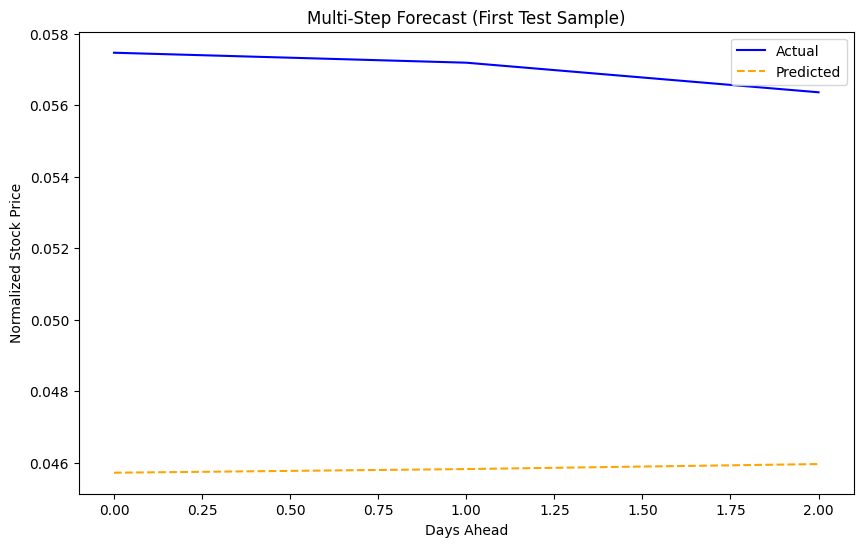

In [62]:
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)

accuracy = 100 - (100 * (test_loss / y_test.mean()))

print(f"Model Accuracy: {accuracy:.2f}%")

# Plot the predictions for the first test sample
plt.figure(figsize=(10, 6))
plt.plot(range(forecast_horizon), y_test[0], label="Actual", color="blue")
plt.plot(range(forecast_horizon), y_pred[0], label="Predicted", color="orange", linestyle="--")
plt.title("Multi-Step Forecast (First Test Sample)")
plt.xlabel("Days Ahead")
plt.ylabel("Normalized Stock Price")
plt.legend()
plt.show()


In [63]:
from sklearn.metrics import r2_score

# Flatten y_test and y_pred
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Calculate R² score
r2 = r2_score(y_test_flat, y_pred_flat)
print(f"Overall R² Score: {r2:.4f}")

Overall R² Score: 0.9939


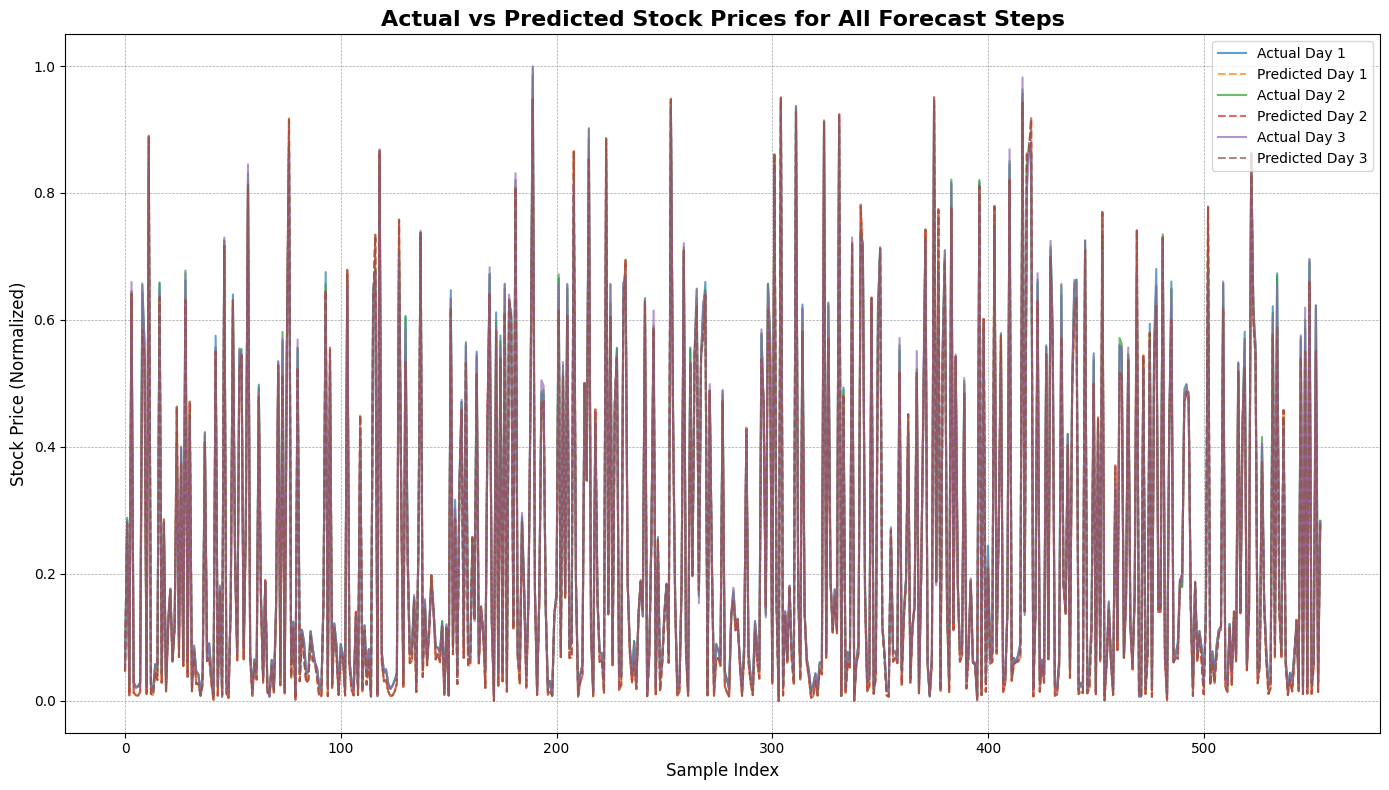

In [64]:
# Plot predictions and actuals for all forecast steps
plt.figure(figsize=(14, 8))

# Loop through each forecast step and plot actual vs predicted
for step in range(y_test.shape[1]):  # Loop over forecast horizon
    plt.plot(y_test[:, step], label=f"Actual Day {step + 1}", alpha=0.7, linewidth=1.5)
    plt.plot(y_pred[:, step], label=f"Predicted Day {step + 1}", linestyle='--', alpha=0.7, linewidth=1.5)

# Add gridlines and details
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Add title and axis labels
plt.title("Actual vs Predicted Stock Prices for All Forecast Steps", fontsize=16, fontweight='bold')
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Stock Price (Normalized)", fontsize=12)

# Add legend
plt.legend(loc="upper right", fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()



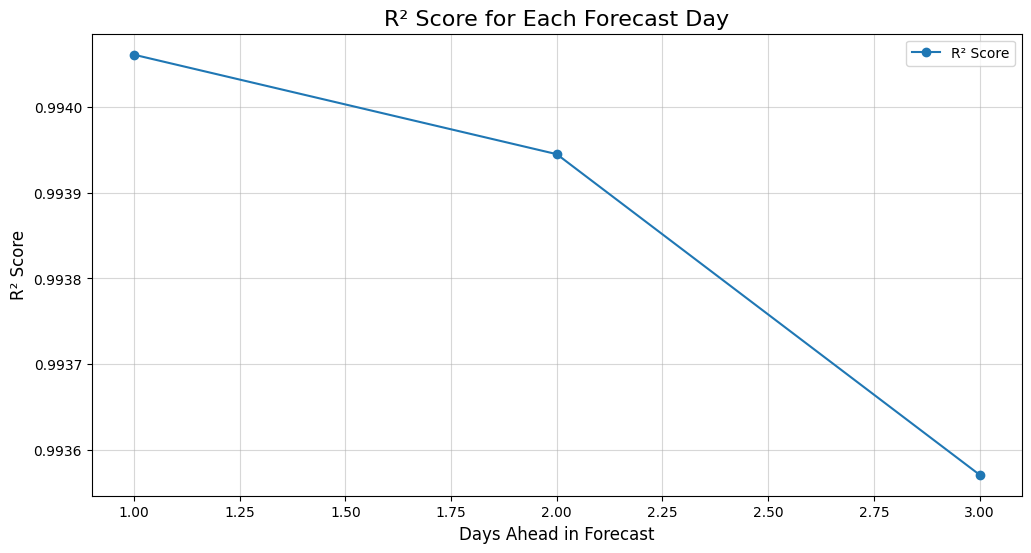

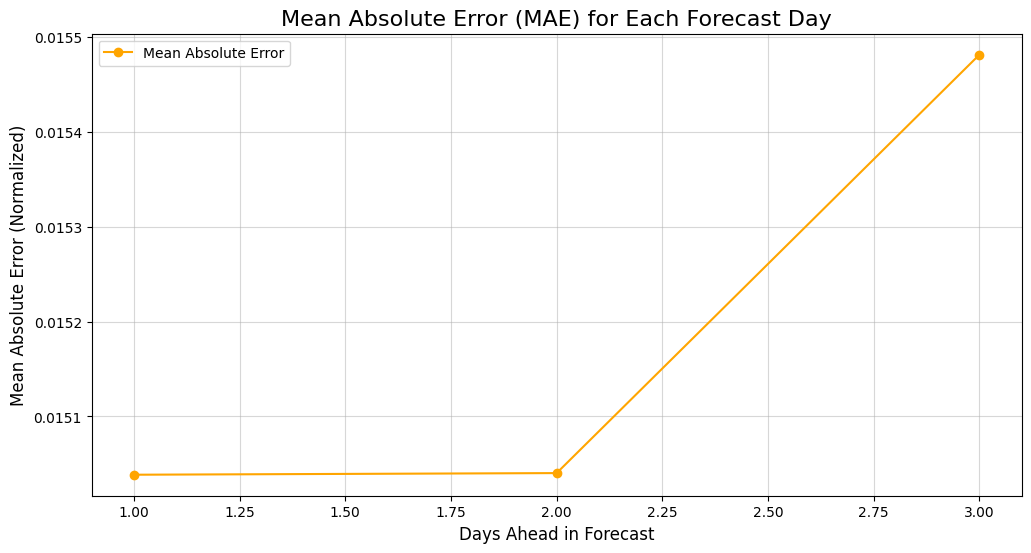

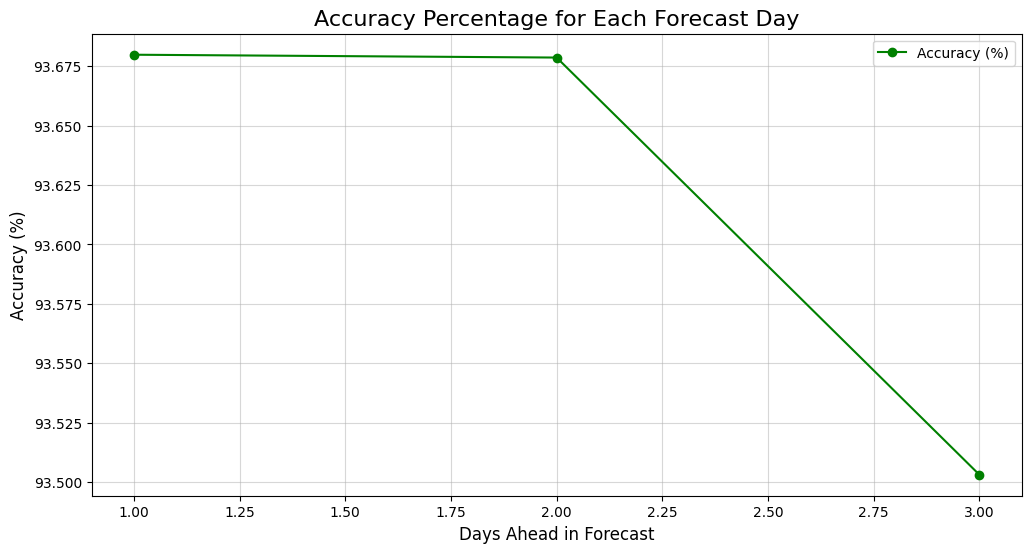

Day 1: Accuracy = 93.68%
Day 2: Accuracy = 93.68%
Day 3: Accuracy = 93.50%


In [65]:
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store metrics
r2_scores = []
mae_scores = []
accuracy_percentages = []

# Loop through each forecast day
for day in range(y_test.shape[1]):  # Iterate over forecast horizon
    r2 = r2_score(y_test[:, day], y_pred[:, day])
    mae = mean_absolute_error(y_test[:, day], y_pred[:, day])
    mean_actual = np.mean(y_test[:, day])
    accuracy = 100 - (mae / mean_actual * 100)

    r2_scores.append(r2)
    mae_scores.append(mae)
    accuracy_percentages.append(accuracy)

# Plot R² Scores
plt.figure(figsize=(12, 6))
plt.plot(range(1, y_test.shape[1] + 1), r2_scores, marker='o', label="R² Score")
plt.title("R² Score for Each Forecast Day", fontsize=16)
plt.xlabel("Days Ahead in Forecast", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

# Plot MAE Scores
plt.figure(figsize=(12, 6))
plt.plot(range(1, y_test.shape[1] + 1), mae_scores, marker='o', color='orange', label="Mean Absolute Error")
plt.title("Mean Absolute Error (MAE) for Each Forecast Day", fontsize=16)
plt.xlabel("Days Ahead in Forecast", fontsize=12)
plt.ylabel("Mean Absolute Error (Normalized)", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

# Plot Accuracy Percentages
plt.figure(figsize=(12, 6))
plt.plot(range(1, y_test.shape[1] + 1), accuracy_percentages, marker='o', color='green', label="Accuracy (%)")
plt.title("Accuracy Percentage for Each Forecast Day", fontsize=16)
plt.xlabel("Days Ahead in Forecast", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

# Print accuracy percentages for reference
for day, acc in enumerate(accuracy_percentages, start=1):
    print(f"Day {day}: Accuracy = {acc:.2f}%")
